# Tutorial: Track your Experiments with Weights & Biases (W&B)

#### [See Part 2 of the series on hyperparameter optimization using W&B here](https://www.kaggle.com/imeintanis/tutorial-cnn-keras-hyperparameter-opt-w-b-p2?scriptVersionId=40022482)

# Introduction (purpose of kernel)

W&B helps you visualize your model performance and predictions, find the best models fast and share insights learned from your models. Here are a few use cases in which W&B can be specially useful for Kagglers:

* Track and compare models - track your experiments easily, test out hypotheses fast and iterate quickly to find the best model
* Visualize model performance for debugging - see how models are performing in real time and debug them
* Efficient hyperparameter search - find the best model faster using sweeps (distributed to many agents!)
* Resource efficient model training - be efficient with model training and share key insights with my teammates and the Kaggle community


As an example we use the famous digits recognition problem (MNIST dataset) and a simple CNN model [Keras TF] (addapted by @yassineghouzam). After the standard data loading and preprocessing routines we will focus on the CNN model and how to build the configuration for the hyperparameter tuning.

In [ ]:
!pip install --upgrade wandb

In [ ]:
import os 
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa

import wandb
from wandb.keras import WandbCallback

# Helpers

In [ ]:
# Load the data
def load_data(path):

    train = pd.read_csv(path+"train.csv")
    test = pd.read_csv(path+"test.csv")
    
    x_tr = train.drop(labels=["label"], axis=1)
    y_tr = train["label"]
    
    print(f'Train: we have {x_tr.shape[0]} images with {x_tr.shape[1]} features and {y_tr.nunique()} classes')
    print(f'Test: we have {test.shape[0]} images with {test.shape[1]} features')
    
    return x_tr, y_tr, test


def seed_all(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Master Params

In [ ]:
DEBUG = False       # set to True in case of testing/debugging
DATA_AUGM = False   # set to True if you wish to add data augmentation 

BATCH_SIZE = 64

if DEBUG:
    EPOCHS = 3          
else: 
    EPOCHS = 40

# Data Preparation

In [ ]:
SEED = 26
PATH = "../input/digit-recognizer/"

seed_all(SEED)

x_train, y_train, x_test = load_data(path=PATH)

Let's check the class distribution before proceed..

In [ ]:
sns.countplot(y_train)
for i in range(9):
    print(i, y_train[y_train==i].count().min())

As we can see from the figure above the classes are quite balanced, that makes our problem and our lives bit easier :)

In [ ]:
# Check the data for NaNs
x_train.isnull().sum().sum(), x_test.isnull().sum().sum()   # .describe()

Sicnce there are no NaN or missing values in the train and test datasets, we can safely proceed with the modelling...

## Normalisation

In [ ]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

## Reshape

Train and test images loaded as 1D vectors of 784 (28 x 28) values. We reshape all data to 4d-tensors of shape: Nx28x28x1

In [ ]:
# Define image sizes and reshape to a 4-dim tensor

IMG_H, IMG_W = 28, 28
NO_CHANNELS = 1           # for greyscale images

# Reshape to a 3-dim tensor
x_train = x_train.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)
x_test = x_test.values.reshape(-1, IMG_H, IMG_W, NO_CHANNELS)


# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=10)

print('Tensor shape (train): ', x_train.shape)
print('Tensor shape (test): ', x_test.shape)
print('Tensor shape (target ohe): ', y_train_ohe.shape)

## Split Training and Validation set

In [ ]:
# Split the train and the validation set for the fitting

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_ohe, test_size=0.15, random_state=SEED)

print('Tensors shape (train):', x_tr.shape, y_tr.shape)
print('Tensors shape (valid):', x_val.shape, y_val.shape)

We can get a better sense by visualising some images..

In [ ]:
# visualize some examples

plt.figure(figsize=(12, 4))
for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# CNN Model


The model is a simple 2d-CNN build using the Keras Functional API (TF backend). The main building blocks and their usage are:

* Convolutional (Conv2D) layer: It is like a set of learnable filters. I choosed to set 32 filters for the first two layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image. The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

* Pooling (MaxPool2D) layer: This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

* Dropout: is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

* Activation function: 'relu' is the rectifier activation function, used to add non linearity to the model.

* Flatten layer: is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

* Fully-connected (Dense) layers: to act as a (NN) classifier. Note that in the last layer (Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Build CNN model 
# CNN architecture: In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

# see original: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 


def build_model():
    
    fs = config.filters         # 32
    k1 = config.kernel_1        #[(5,5), (3,3)]
    k2 = config.kernel_2        # [(5,5), (3,3)]
    pad = config.padding
    activ = config.activation   # 'relu'
    pool = config.pooling       # (2,2)
    dp = config.dropout         # 0.25
    dp_out = config.dropout_f   # 0.5
    dense_units = config.dense_units  # 256
    
    inp = Input(shape=(IMG_H, IMG_W, NO_CHANNELS))     # x_train.shape[1:]
    
    # layer-1:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs, kernel_size=k1, padding=pad, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(dp)(x)    
    
    # layer-2:: CNN-CNN-(BN)-Pool-dp
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(inp)
    x = Conv2D(filters=fs*2, kernel_size=k2, padding=pad, activation=activ)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    x = Dropout(dp)(x)  
    
    x = Flatten()(x)
    #     x = GlobalAveragePooling2D()(x)
    
    # FC head
    x = Dense(dense_units, activation=activ)(x)
    x = Dropout(dp_out)(x)
    
    out = Dense(10, activation="softmax")(x)
    
    model = tf.keras.models.Model(inp, out)
    
    print(model.summary())
    return model



In [ ]:
# you may also experiment with this arhitecture (see credits)
# https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist/notebook#Train-15-CNNs

def build_lenet():
    
    fs = config.filters         # 32
    #     k1 = config.kernel_1        #[(5,5), (3,3)]
    #     k2 = config.kernel_2        # [(5,5), (3,3)]
    #     pad = config.padding
    activ = config.activation   # 'relu'
    dp = config.dropout         # 0.25
    
    
    inp = Input(shape=(28, 28, 1)) 
    
    
    
    x = Conv2D(fs, kernel_size = 3, activation=activ)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = 3, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs, kernel_size = 5, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(fs*2, kernel_size = 3, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = 3, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Conv2D(fs*2, kernel_size = 5, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, kernel_size = 4, activation=activ)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    out = Dense(10, activation='softmax')(x)
    
    model = tf.keras.models.Model(inp, out)

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    #     model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Configure WandB


### 1. Start by setting up your free W&B account in Weights & Biases webpage (or sign-in if you already have one)


Helpful commands to get started with W&B:

- `import wandb` – Import the wandb library
- `wandb.keras.WandbCallback()` – Fetch all model parameters and log them automatically to your W&B dashboard (for Keras/TF)

- `wandb.init()` - Initialize a new W&B run. Each run is single execution of the training script.

- `wandb.log()` - Logs custom objects like images, videos, audio files, HTML, plots, point clouds etc.

- `wandb.agent()` - start running an agent in your machine (used in sweep)

- `wandb.config` – Save all your hyperparameters in a config object

- `%%wandb` - Add this at the top of a cell to show model metrics live below the cell

### 2. Make a New Project (or go to an existing one) and choose a framework (optional) e.g. Keras


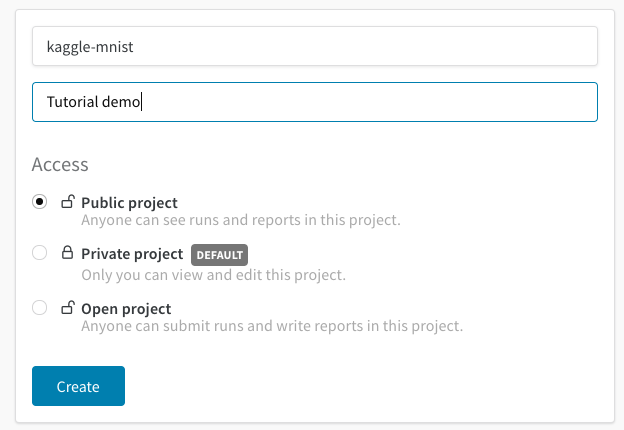

### 3. Next, we select a framework to start working on. For our example here, we choose Keras.

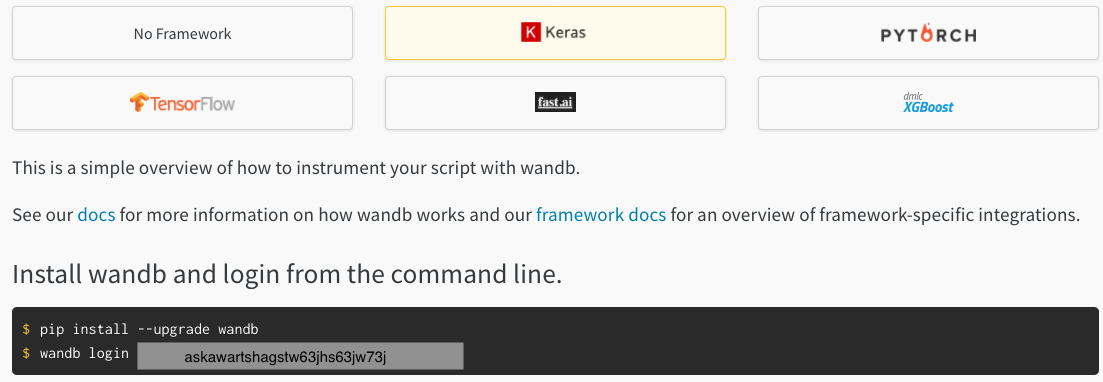

Note: Keep aside your username and login token (API key)

### 4. Login to W&B

From the command line or inside a nb cell run `!wandb login <your_API_key>` to login and initiate W&B

or, use the `wandb.login()` function and copy and paste the API key when asked

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("API_key")

In [ ]:
!wandb login $api_key

### 5. Create the W&B configuration

Let's make a dictionary with all the hyperparameters that we'd like to track! For CNN type models I usually keep track of the following params:

- filters
- kernel size
- learning rate (init)
- optimizer
- dense units
- dropout rate etc

But you can add as many others you like.

In [ ]:
hyperparams = dict(
    filters = 64,
    kernel_1 = (5,5),
    kernel_2 = (3,3),
    padding = 'same',
    pooling = (2,2),
    lr = 0.001,
    wd = 0.0,
    lr_schedule = 'RLR',    # cos, cyclic, step decay
    optimizer = 'Adam+SWA',     # RMS
    dense_units = 256,
    activation = 'elu',      # elu, LeakyRelu
    dropout = 0.25,
    dropout_f = 0.5,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
)

In [ ]:
wandb.init(project="kaggle-mnist", config=hyperparams)
config = wandb.config

From now on whenever we want to assign/access a hp we'll use the config.variable accessor.

Let's check that we have all the parameters defined...

In [ ]:
config.keys()

# Build and compile the model

To compile and eventually train our model, we need to set up

- **a loss function** - to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy", which is an extension of BinaryCrossEntropy for n-classes.

- **an optimisation algorithm (optimizer)** - that will try to minimize the loss function by iteratively changing the weights and biases of neurons

- **a score metric (optional)** - "accuracy" is used is to evaluate the performance of our model (used only for evaluation).

In [ ]:
model = build_model()

In [ ]:
# Define the optimizer

LR = config.lr     # 0.001

if config.optimizer=='Adam':
    opt = Adam(LR)
elif config.optimizer=='RMS':
    opt = RMSprop(lr=LR, rho=0.9, epsilon=1e-08, decay=0.0)
elif config.optimizer=='Adam+SWA':
    opt = Adam(LR)
    opt = tfa.optimizers.SWA(opt)
else: 
    opt = 'adam'    # native adam optimizer 
    
    
# Compile the model
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

## Set Callbacks

In [ ]:
# mdl_path = '../input/output/'

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, verbose=1),
    #    ModelCheckpoint(mdl_path+'best_model.h5')
    ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose=1, factor=0.5, min_lr=1e-4), 
    WandbCallback(monitor='val_loss')
]

## Data augmentation (optional)

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.


For the data augmentation :

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height

In [ ]:
if DATA_AUGM:
    
    # copied data generator 
    
    datagen = ImageDataGenerator(
        featurewise_center=False,                  # set input mean to 0 over the dataset
        samplewise_center=False,                   # set each sample mean to 0
        featurewise_std_normalization=False,       # divide inputs by std of the dataset
        samplewise_std_normalization=False,        # divide each input by its std
        zca_whitening=False,                       # apply ZCA whitening
        rotation_range=10,                         #  randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                          #  Randomly zoom image 
        width_shift_range=0.1,                     # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                    # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                     # randomly flip images
        vertical_flip=False)                       # randomly flip images

    datagen.fit(x_train)

In [ ]:
# # Fit the model

# if DATA_AUGM:
#     # With data augmentation to prevent overfitting (accuracy: 0.99286)
#     hist = model.fit_generator(datagen.flow(x_train, y_train_ohe, batch_size=BATCH_SIZE),
#                                epochs=EPOCHS, 
#                                validation_data=(x_val, y_val),
#                                verbose=1, 
#                                steps_per_epoch=x_train.shape[0] // BATCH_SIZE, 
#                                callbacks=callbacks)
    
# else: 
#     # Without data augmentation (accuracy: 0.98114)
#     hist = model.fit(x_train, y_train_ohe, 
#                      batch_size=config.batch_size,    # BATCH_SIZE, 
#                      epochs=config.epochs,            # EPOCHS, 
#                      validation_data=(x_val, y_val), 
#                      callbacks=callbacks,
#                      verbose=1) 

# Training model

In [ ]:
hist = model.fit(x_train, y_train_ohe, 
                     batch_size=config.batch_size,    # BATCH_SIZE, 
                     epochs=config.epochs,            # EPOCHS, 
                     validation_data=(x_val, y_val), 
                     callbacks=callbacks,
                     verbose=1) 

# Evaluate model

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

After you have your first run logged succesfully, you will be able to visualize the standard metrics in the wandb site

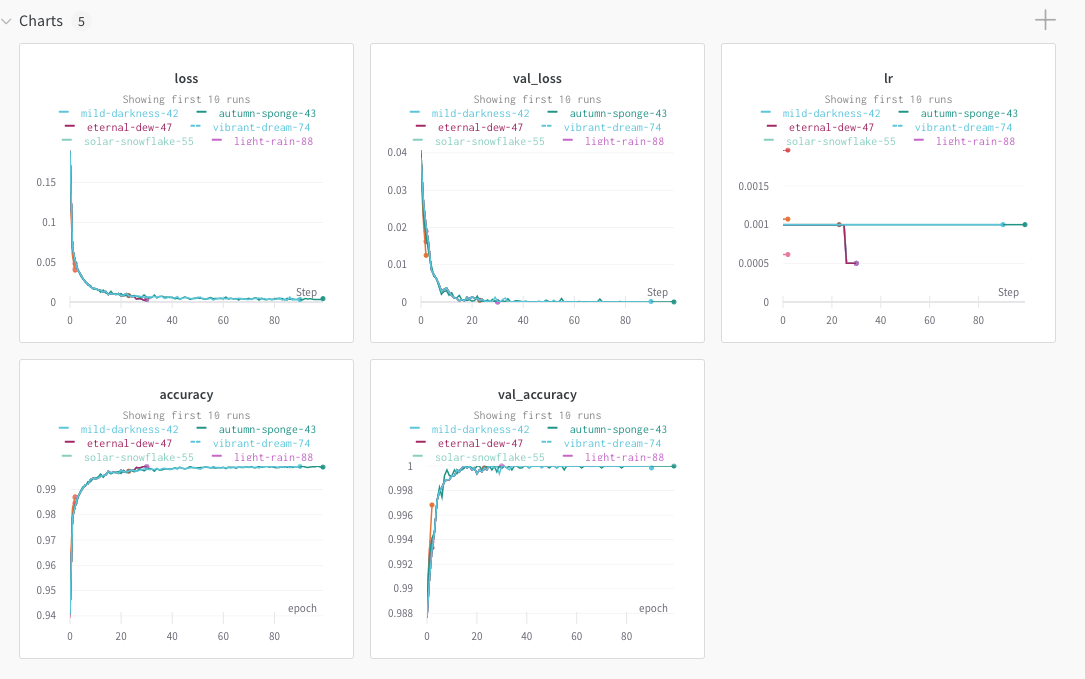

## Confusion Matrix

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(cm, classes=range(10)) 

Lets's also create a confusion matrix with W&B so we can view it in our dashboard

In [ ]:
# Confusion Matrix
wandb.sklearn.plot_confusion_matrix(Y_true, Y_pred_classes, labels=range(10))

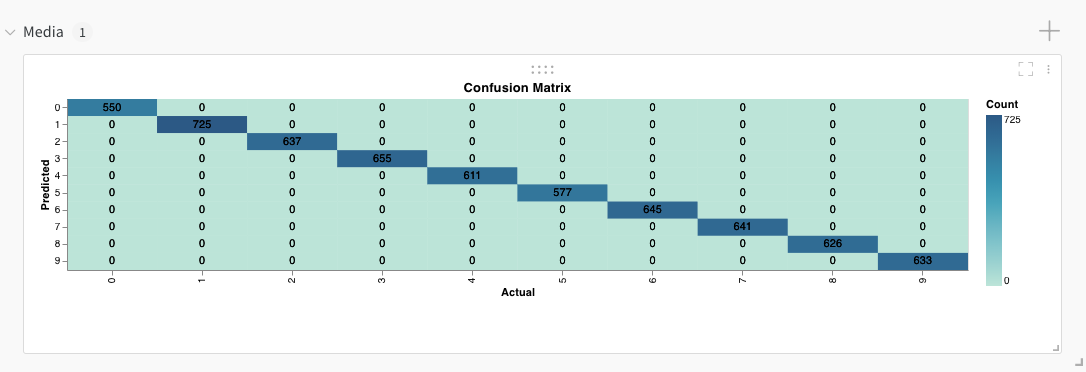

## Predict Test set & Submit

Althought the purpose of the kernel is for learning, let's test our model in the LB 

In [ ]:
# predict results
results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist.csv",index=False)

# Hyperparameter Optimization


### [Go to Part 2: Hyperparameter Optimization](https://www.kaggle.com/imeintanis/tutorial-cnn-keras-hyperparameter-opt-w-b-p2?scriptVersionId=40022482)


# Resources

- W&B tutorial: https://www.kaggle.com/lavanyashukla01/better-models-faster-with-weights-biases/notebook
- W&B docs sweep: https://docs.wandb.com/sweeps/python-api

## Inspiring kernels 
- Chriss Deotte - [25 Million Images! [0.99757] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist)

- Yassine Ghouzam - [introduction-to-cnn-keras-0-997-top-6](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

### Please, if you found this notebook helpful or you just liked it, some upvotes would be very much appreciated :)